# Analyzing CMIP6 Precipitation Statistics Using Histograms

## packages

In [1]:
# imports
import numpy as np
import xarray as xr
import dask.array as da
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib.lines import Line2D
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
warnings.filterwarnings('ignore')

# my lib
from importlib import reload
import cmip6_lib

In [2]:
# if you changed something in cmip6_lib.py
reload(cmip6_lib)

<module 'cmip6_lib' from '/export/data1/hgpeterson/ResearchSchneider/cmip_analysis/cmip6_lib.py'>

## run functions

In [3]:
"""
    precip, hist, bins = get_precip_pdf(dfiles, nbins)
    
Get the precipitation pdf from CMIP6 data.
"""
def get_precip_pdf(dfiles, nbins, timeslice, latslice, lonslice):
    # using open_mfdataset for multiple files
    ds = xr.open_mfdataset(dfiles)
    pr = ds["pr"] # this is precipitation flux in units of kg m-2 s-1

    # convert to precipitation
    dt = 24*60*60  # 24 hours
    rho = 1e3      # density of water in kg m^-3
    m_to_mm = 1e3  # convert meters to milimeters
    precip = m_to_mm*pr*dt/rho # units of mm during 24 hrs
    
    # time and space slice
    if latslice == "extrop":
        precip = precip.sel(time=timeslice, lon=lonslice).where(np.abs(precip.lat) >= 30, drop=True)
    else:
        precip = precip.sel(time=timeslice, lat=latslice, lon=lonslice)
    
    # weight by cos(ϕ)
    weights = da.ones_like(precip)
    cosϕ = np.cos(np.deg2rad(precip.lat))
    weights *= np.tile(cosϕ, (len(precip.lon), 1)).T
    precip *= weights
    
    # setup bins
    pmin = 10**-5
    pmax = 10**4
    bins = np.zeros(nbins)
    bins[1:] = 10**np.linspace(np.log10(pmin), np.log10(pmax), nbins-1) # include 0 as a bin

    # compute pdf
    hist, bins = da.histogram(precip, bins=bins, density=False)    
    
    # actually compute
    hist = hist.compute()
    
    return precip, hist, bins

"""
    precip_c, hist_c, bins_c, precip_w, hist_w, bins_w = get_ctrl_warm_ssp585(dfiles, nbins, latslice, lonslice)
    
Compute pdfs for control and warmed states of ssp585 scenario.
"""
def get_ctrl_warm_ssp585(dfiles, nbins, latslice, lonslice):
    # control: first 20 years
    print("computing control hist")
    timeslice = slice("2015", "2035")
    precip_c, hist_c, bins_c = get_precip_pdf(dfiles, nbins, timeslice, latslice, lonslice)
    
    # warming: last 20 years
    print("computing warming hist")
    timeslice = slice("2080", "2100")
    precip_w, hist_w, bins_w = get_precip_pdf(dfiles, nbins, timeslice, latslice, lonslice)

    return precip_c, hist_c, bins_c, precip_w, hist_w, bins_w
    
"""
    save_data_ssp585(filename, bins_c, hist_c, bins_w, hist_w)
"""
def save_data_ssp585(filename, bins_c, hist_c, bins_w, hist_w):
    np.savez(filename, bins_c=bins_c, hist_c=hist_c, bins_w=bins_w, hist_w=hist_w)
    print(filename)
    
"""
    bins_c, hist_c, bins_w, hist_w = load_hist_data_ssp585(filename)
"""
def load_hist_data_ssp585(filename):
    data = np.load(filename)
    bins_c = data["bins_c"]
    hist_c = data["hist_c"]
    bins_w = data["bins_w"]
    hist_w = data["hist_w"]
    return bins_c, hist_c, bins_w, hist_w

"""
    pctls, precip_pctls_c, precip_pctls_boot_c, precip_pctls_w, precip_pctls_boot_w, μ_c, σ_c, μ_w, σ_w, ΔT = load_pctls_data_ssp585(filename)
"""
def load_pctls_data_ssp585(filename):
    data = np.load(filename)
    pctls = data["pctls"]
    precip_pctls_c = data["precip_pctls_c"]
    precip_pctls_boot_c = data["precip_pctls_boot_c"]
    precip_pctls_w = data["precip_pctls_w"]
    precip_pctls_boot_w = data["precip_pctls_boot_w"]
    μ_c = data["μ_c"]
    σ_c = data["σ_c"]
    μ_w = data["μ_w"]
    σ_w = data["σ_w"]
    ΔT = data["ΔT"]
    return pctls, precip_pctls_c, precip_pctls_boot_c, precip_pctls_w, precip_pctls_boot_w, μ_c, σ_c, μ_w, σ_w, ΔT

## compute pdfs for control and warming

In [4]:
# bins
nbins = 1000

# lat slice
# latslice = slice(-90, 90)
# latslice = slice(-30, 30)
latslice = "extrop"

# lon slice
lonslice = slice(0, 360)

# model descriptions
variable_name = "pr"
frequency_value = "day"
experiment_id = "ssp585"
variant_label = "r1i1p1f1"
if latslice == slice(-90, 90):
    domain = ""
elif latslice == slice(-30, 30):
    domain = "trop_"
elif latslice == "extrop":
    domain = "extrop_"
print(domain)

# folder
path = "/export/data1/hgpeterson/cmip6/" + variable_name + "_" + frequency_value + "_" + experiment_id + "/"

# make an array of source_id's and grid_label's to choose from
file_list = cmip6_lib.get_file_list(path)

extrop_


In [ ]:
# loop through models
for [source_id, grid_label] in file_list:
    # get file names structure
    filenames = variable_name + "_" + frequency_value + "_" + source_id + "_" + experiment_id + "_" + variant_label + "_" + grid_label + "_*.nc"
    dfiles = path + filenames
    print("\n" + filenames)

    precip_c, hist_c, bins_c, precip_w, hist_w, bins_w = get_ctrl_warm_ssp585(dfiles, nbins, latslice, lonslice)
    savefile = "data/hists_{}{}.npz".format(domain, filenames[:-5])
    save_data_ssp585(savefile, bins_c, hist_c, bins_w, hist_w)

## plots


1.973054156142856 5.8009907552644435
trop_
3.549287714891907 8.909280695695848
extrop_
1.1930429709016677 3.320906045842319


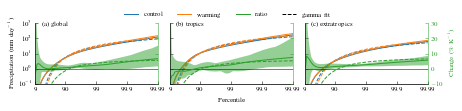

In [5]:
### multimodel mean

n_models = len(file_list)

# init plot
nrows = 1
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(3.404*2, 3.404*2/ncols/1.62*nrows), sharey=True)
axes[0].set_ylabel("Precipitation (mm day$^{-1}$)")
axes[1].set_xlabel("Percentile")
axes[0].annotate("(a) global", (0.05, 0.95), xycoords="axes fraction")
axes[1].annotate("(b) tropics", (0.05, 0.95), xycoords="axes fraction")
axes[2].annotate("(c) extratropics", (0.05, 0.95), xycoords="axes fraction")
custom_lines = [Line2D([0], [0], ls="-", c="tab:blue"),
               Line2D([0], [0], ls="-", c="tab:orange"),
               Line2D([0], [0], ls="-", c="tab:green"),
               Line2D([0], [0], ls="--", c="k")]
custom_handles = ["control", "warming", "ratio", "gamma fit"]
axes[0].legend(custom_lines, custom_handles, ncol=4, loc=(0.7, 1.05))

# loop through domains and models
i = 0
for i, domain in enumerate(["", "trop_", "extrop_"]):
    print(domain)
    ax = axes[i]
    # keep running means
    control = 0
    warming = 0
    ratio_error = 0
    ΔT_mean = 0
    j = 0
    for [source_id, grid_label] in file_list:   
        # get file names structure
        fbase = variable_name + "_" + frequency_value + "_" + source_id + "_" + experiment_id + "_" + variant_label + "_" + grid_label
        filename_hists = "data/hists_" + domain + fbase    
        filename_pctls = "data/pctls_" + domain + fbase    
        filename_pctls_global = "data/pctls_" + fbase
        
        bins_c, hist_c, bins_w, hist_w = load_hist_data_ssp585(filename_hists + ".npz")
        pctls, precip_pctls_c, precip_pctls_boot_c, precip_pctls_w, precip_pctls_boot_w, μ_c, σ_c, μ_w, σ_w, ΔT_global = load_pctls_data_ssp585(filename_pctls_global + ".npz")
        pctls, precip_pctls_c, precip_pctls_boot_c, precip_pctls_w, precip_pctls_boot_w, μ_c, σ_c, μ_w, σ_w, ΔT = load_pctls_data_ssp585(filename_pctls + ".npz")

        # bootstrap intervals
        precip_pctls_c_low  = np.percentile(precip_pctls_boot_c, 2.5,  axis=0)
        precip_pctls_c_high = np.percentile(precip_pctls_boot_c, 97.5, axis=0)
        precip_pctls_w_low  = np.percentile(precip_pctls_boot_w, 2.5,  axis=0)
        precip_pctls_w_high = np.percentile(precip_pctls_boot_w, 97.5, axis=0)
        # ratios
        ratio_low = 100*(precip_pctls_w_low/precip_pctls_c_high - 1)/ΔT_global
        ratio_high = 100*(precip_pctls_w_high/precip_pctls_c_low - 1)/ΔT_global
        
        # add to running means (or initialize them if needed)
        control += hist_c
        warming += hist_w
        if type(ratio_error) == int:
            ratio_error = np.vstack((ratio_low, ratio_high))
            
            ratios = np.zeros((n_models, len(pctls)))
            ratios[j, :] = 100*(precip_pctls_w/precip_pctls_c - 1)/ΔT_global
            j += 1
        else:
            ratio_error = np.vstack((ratio_error, ratio_low, ratio_high))
            
            ratios[j, :] = 100*(precip_pctls_w/precip_pctls_c - 1)/ΔT_global
            j += 1
        
        # warming
        ΔT_mean += ΔT_global
       
    # done with models, divide by N
    ΔT_mean /= n_models
    
    # compute k_c, θ_c from bins
    k_c, θ_c = cmip6_lib.gamma_fit_from_hist(bins_c, control)
    
    # compute mean scaling
    μ_c, σ_c = cmip6_lib.get_mean_std_from_hist(bins_c, control)
    μ_w, σ_w = cmip6_lib.get_mean_std_from_hist(bins_w, warming)
    mean_scaling = μ_w/μ_c - 1
    print(μ_c, σ_c)
    
    # compute extreme scaling     
    pctls_c, precip_func_c = cmip6_lib.hist_to_pctls(bins_c, control)
    pctls_w, precip_func_w = cmip6_lib.hist_to_pctls(bins_w, warming)
    extreme_scaling = precip_func_w(0.99999)/precip_func_c(0.99999) - 1
    
    # warming fit based on theory
    θ_w_theory = θ_c*(1 + extreme_scaling)
    k_w_theory = k_c*(1 + mean_scaling - extreme_scaling)

    # plot
    axtwin = cmip6_lib.pctl_plot_hist(ax, ΔT_mean, bins_c, control, k_c, θ_c, bins_w, warming, k_w_theory, θ_w_theory)
    
    # add ratios
    ratio = np.nanmean(ratios, axis=0)
    ratio_low  = np.nanmin(ratio_error, axis=0)
    ratio_high = np.nanmax(ratio_error, axis=0)
    axtwin.plot(cmip6_lib.x_transform(pctls), ratio, color="tab:green")
    axtwin.fill_between(cmip6_lib.x_transform(pctls), ratio_low, ratio_high, alpha=0.5, lw=0, color="tab:green")
    
    # label
    if i == 2:
        axtwin.set_ylabel("Change (\% K$^{-1}$)", c="tab:green")
    else:
        axtwin.set_yticklabels([])

plt.subplots_adjust(bottom=0.2, top=0.8, left=0.1, right=0.9, wspace=0.1, hspace=0.1)
plt.savefig("multimodelmean.png")
plt.savefig("multimodelmean.pdf")